In [ ]:
import sys
!{sys.executable} -m pip install beautifulsoup4 lxml html5lib

In [ ]:
import csv
from bs4 import BeautifulSoup
import requests

# skip_list = ['…','！','？','「','」','。', '，', '、', '：', '“', '”', "《", "》", '\n','；','— —','（', '）']
# skip_str = "".join(str(e) for e in skip_list)

headers = {
    'accept': '*/*',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'referer': 'https://www.google.com',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36 Edg/85.0.564.44'
}

def get_article(card):
    """Extract article information from the raw html"""
    headline = card.find('div', 'newsFeed_item_title').text.replace('…', '').strip()
    description = card.find('div', 'sc-cbKXXB').text.replace('…', '').strip()
    raw_link = card.parent.parent.get('href')
    response = requests.get(raw_link, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    article_body = soup.find('div', 'article_body')
    if article_body:
        article_body = soup.find('div', 'article_body').text.replace('\n', ' ').strip()
    article = (headline , description , article_body)
    return article

def get_the_news(search):
    """Run the main program"""
    template = 'https://news.yahoo.co.jp/search?p={}'
    url = template.format(search)
    articles = []
    
    while True:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        cards = soup.find_all('div', 'newsFeed_item_text')
        # extract articles from page
        for card in cards[:10]:
            article = get_article(card)
            articles.append(article)
            with open('news.csv', 'a', newline='', encoding='utf-8') as f:
                writer = csv.writer(f)
                # writer.writerow(['Headline','Description'])
                writer.writerows(articles)  
            articles = []    
        break   # break the loop when no more pages
    return articles # return the list of articles

# run the main program
articles = get_the_news('仕事')
articles = get_the_news('スポーツ')
articles = get_the_news('IT')
articles = get_the_news('理科')

In [ ]:
import jieba

with open('news.csv') as f:
    japanese_text = f.read()
    japanese_text = japanese_text.split()
print(len(japanese_text))
texts = []
for sentence in japanese_text:
    texts.append(jieba.cut(sentence))
texts = [[word for word in text if len(word)>1] for text in texts]
with open('thesaurus.txt', 'w') as filehandle:
    for listitem in texts:
        filehandle.write("\n".join(map(lambda x: str(x), listitem)))

In [3]:
with open('thesaurus.txt', 'r') as f:
    words = [line.rstrip('\n') for line in f]

words[1:10]

['最高', '判断', '異議', 'LY', '投稿', '違法', '地域', '仕事', '学校']

In [4]:
from collections import Counter

def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

# words = preprocess(text)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 4534
Unique words: 2199


In [5]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[270, 770, 32, 778, 60, 788, 790, 277, 277, 427, 434, 792, 438, 194, 447, 459, 461, 1, 20, 67, 466, 280, 281, 802, 805, 480, 807, 808, 201, 811]


In [6]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [7]:
# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [3, 4, 6, 7]


In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    n_batches = len(words)//batch_size
    # only full batches
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [9]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 0, 2, 3, 0, 1, 3, 0, 1, 2]


In [10]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [11]:
import torch
from torch import nn
import torch.optim as optim

In [12]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

In [22]:
# check if GPU is available
CUDA_LAUNCH_BLOCKING=1.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 50
steps = 0
epochs = 100

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

地域 | 敬意, BMWM4, 少年森田, 派遣45, 金情業界
愛犬 | 70099宅副業, 男女, 開示開示, 示唆今回, PDAAIDC
雇用 | 場景, 魅惑, IT, 事例, 加納三宮
37 | 合格率, 知的財, 市場, 文化, 突然
時代 | 企業終身, 本当, 未婚, 友近, 嘉弥真
昨年 | 独自, 赴任, 想起, 取引, 11
公立 | 予告, 記憶力, 知的財, 高校, 独占祝福
橋本 | 100%, 保奈美画像, 金凄, 卒業, TBS
景色 | 未婚, 即妙, 世代, 世界秀島完全, 大生著者
岡賢次 | 空間話題, 立憲, 先天, 条件, 未来面白立軸
第二期 | 設置, 陸上漁師, 理想ON, 設定山縣, 報告業振興提供
地方森田 | 現状, 着手, 里子, bizSPA2022, 安定
事情浦安魚 | 57mm, 環境比較, 診断, 住所, IE
各店 | 1624mm, 設定山縣, S55, 全面, PHEV
漫画 | 自民党, 38, 日曜, 真夏, 上半期
魚市場 | 出身神奈川秀島, 電欠, 記憶, 半面, 感謝結果
...
仕事 | 完璧, 活動男女, AI, 4100, 状態秀島
相手 | 心地, 1958, 30dBm, 文化, 世界秀島完全
学校 | 85, 目指, 部委, 横置, 最初
非正規 | 共通, 現代, IP65, 6000, 全高
12 | 方法, 1971, 4100, 無理安全, 内装色
続距離 | Fastcampus, 理解, 仲良, 以前, 中国
分野 | 台上, 展示同館, 丁目, 埋立, 運用
時代 | 企業終身, 本当, 未婚, 友近, 嘉弥真
人任 | 特有, AFPTogetter, comDeepL, 面白, 浦安市
堀江 | 支持, 漁業, 高橋, 存在秀島, 程度
原因浦安市 | Kinwun, 32, 2019, LDH, 一緒
食育 | 今年, SS14, 密集森田, 著者, 結成森田
天国 | 国民, 皮膚, 270, 住宅, 100%
身近 | 25, 傾向, 可能性, 同士, 出会
形成立地 | 8600, 主要, 記事副業, 同氏, 内容
島国 | 803, 国時代, 同時, 解体現在, 強力
...


In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [24]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()
torch.save(model.state_dict(), 'model.pt')

In [25]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
embed.weight 	 torch.Size([2199, 300])
output.weight 	 torch.Size([2199, 300])
output.bias 	 torch.Size([2199])


In [26]:
model =SkipGram(len(vocab_to_int), embedding_dim).to(device)
model.load_state_dict(torch.load('model.pt'))
embeddings = model.embed.weight.to('cpu').data.numpy()

In [27]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

/home/julkarnine/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/julkarnine/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


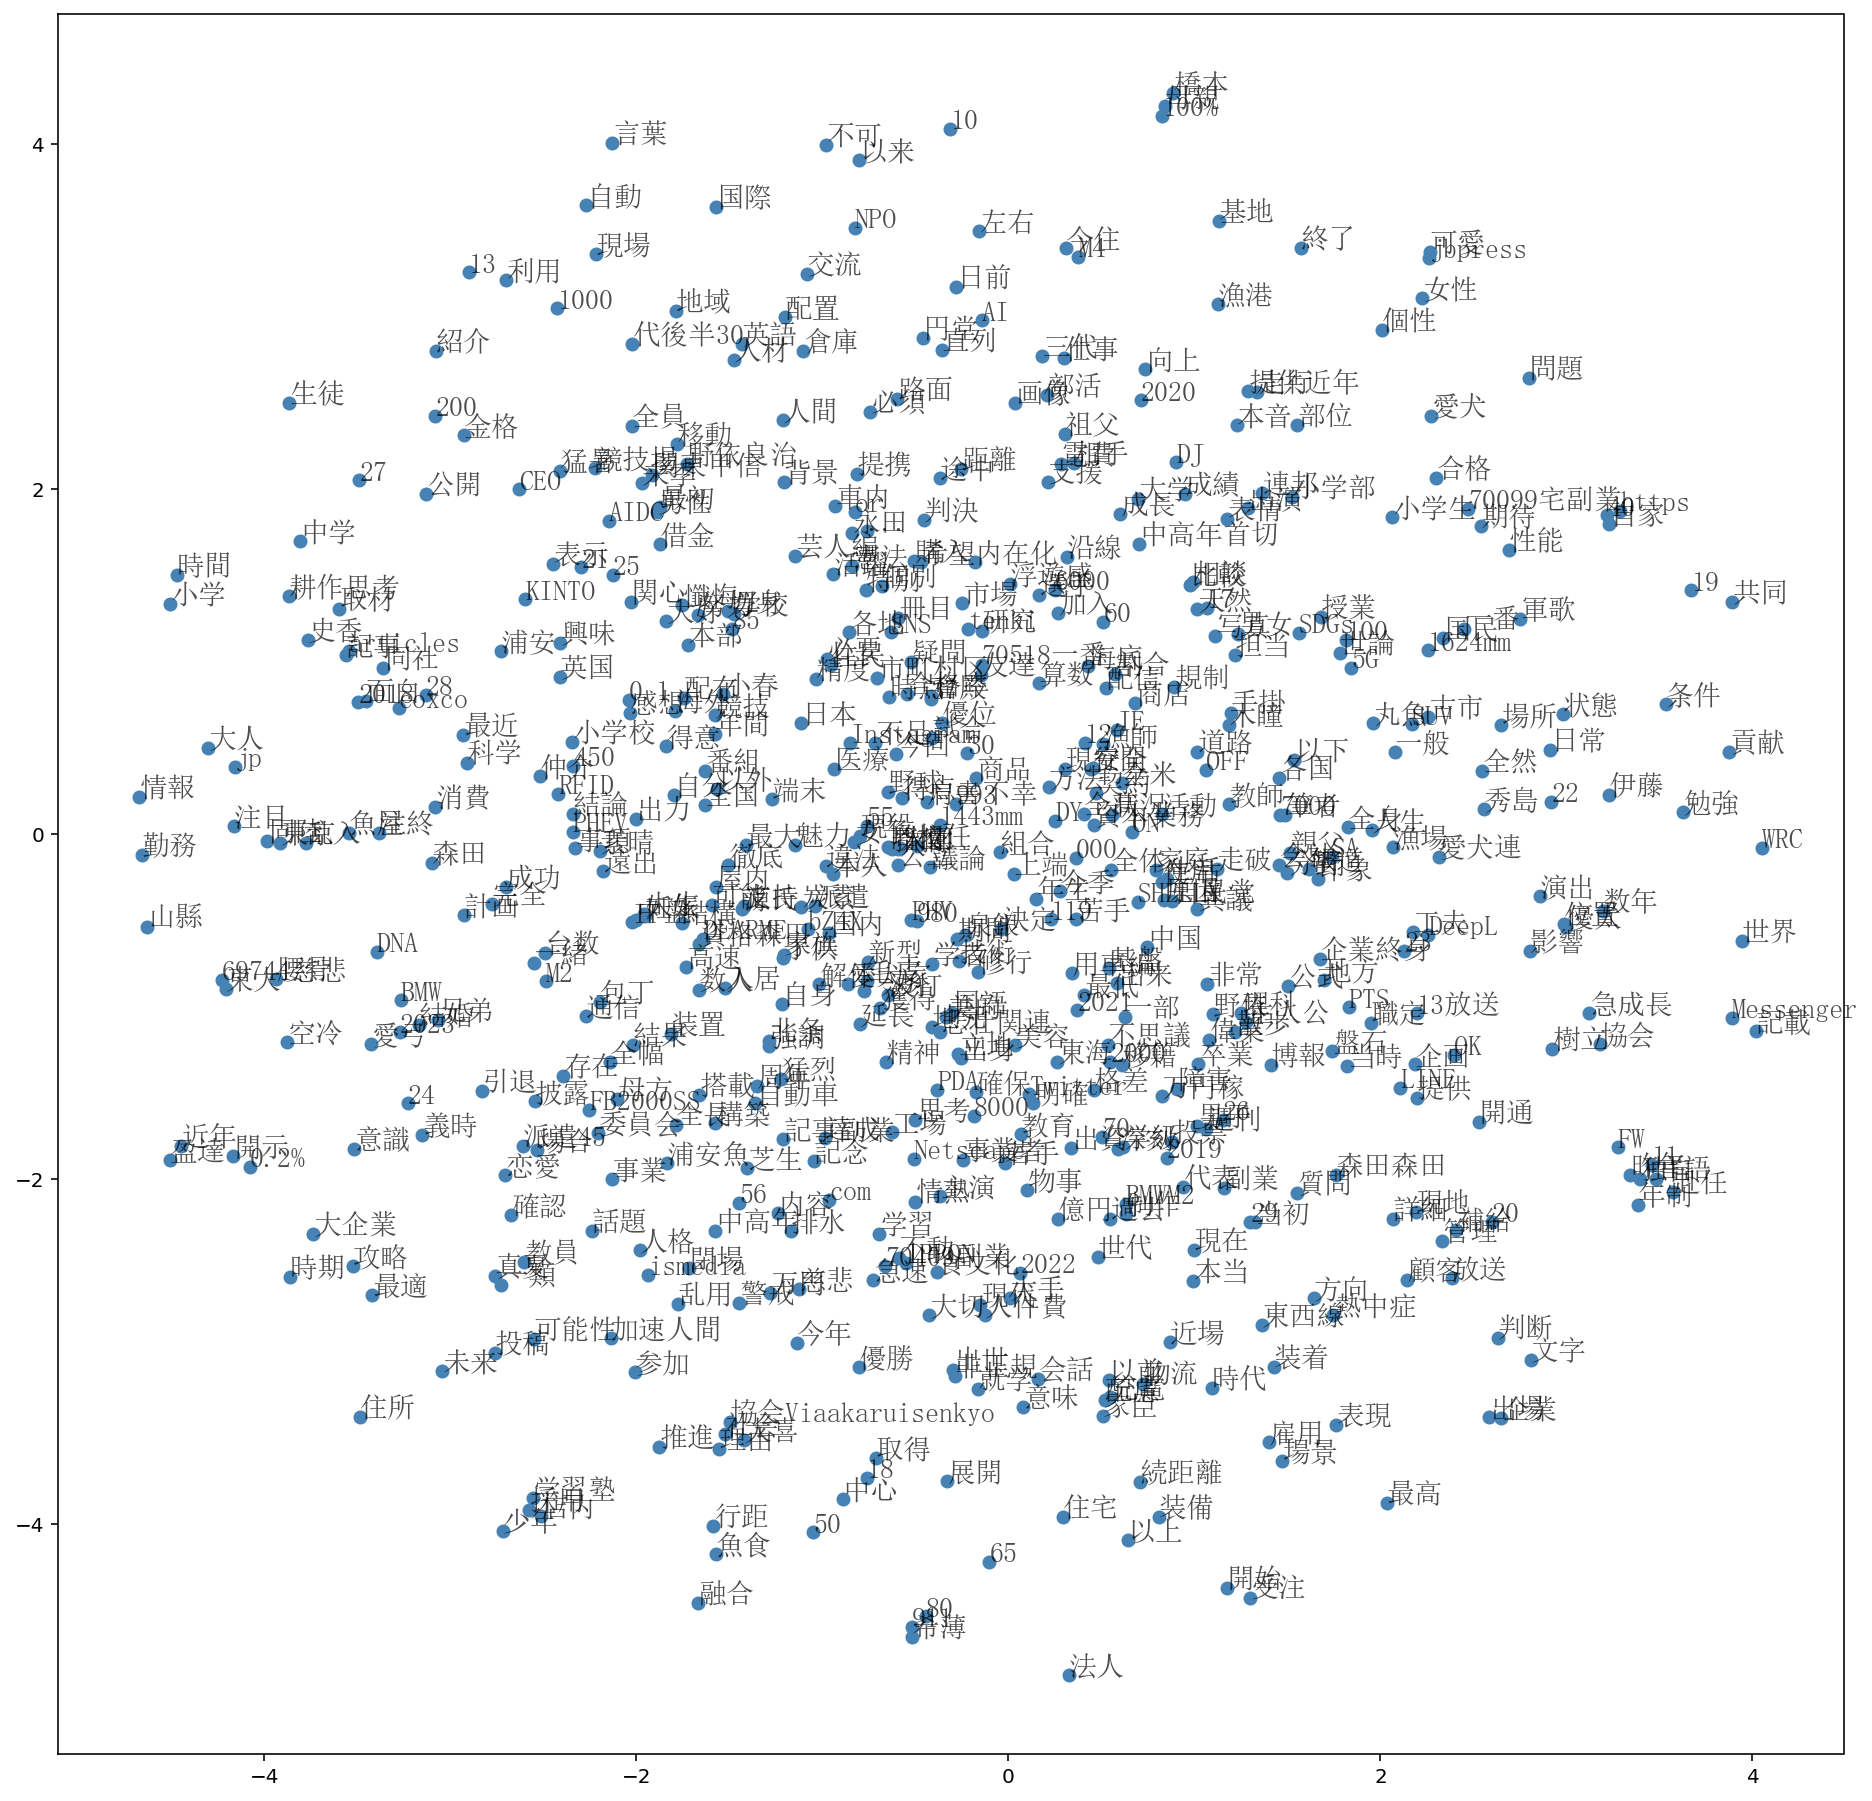

In [28]:
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname=r'simsun.ttc', size=14)

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7 , fontproperties=fp)
    